# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [2]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [3]:
# recherche fichiers POIDS : format data_BEN_xxxxxx.zip

# Source : Withings https://healthmate.withings.com/

# Account > User > Parameters > Download ==> data_BEN_xxxxx.zip ==> contient weight.csv

pattern_poids = "^data_BEN_[\d]+[.]zip"
eng = re.compile(pattern_poids)
liste_zip_poids = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un data_BEN_dddd.zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_poids.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_poids) == 0:
    raise NameError(f'Aucun fichier de type data_BEN_xxxx.zip contenant \
        les données poids ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_poids)

idx = np.argmax(liste_mtime_zips)
filename_poids = liste_zip_poids[idx]

print(f"Le fichier poids le plus récent est : {filename_poids}, parmi :\n")
for f in liste_zip_poids:
    print(f"{f}")

Le fichier poids le plus récent est : data_BEN_1704009310.zip, parmi :

data_BEN_1703831989.zip
data_BEN_1704009310.zip
data_BEN_1703920479.zip


In [4]:
# recherche fichiers FOOD : format File-Export-YYYY-MM-DD-to-YYYY-MM-DD.zip

# https://www.myfitnesspal.com/reports

# www.myfitnesspal.com ==> reports > export data ==> File-Export-date1-to-date2.zip

pattern_food = "^File-Export-[\d]{4}-[\d]{2}-[\d]{2}-to-[\d]{4}-[\d]{2}-[\d]{2}.*[.]zip"
eng = re.compile(pattern_food)
liste_zip_food = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un File-Export-....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_food.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_food) == 0:
    raise NameError(f'Aucun fichier de type File-Export-xxxx.zip contenant \
        les données food ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_food)

idx = np.argmax(liste_mtime_zips)
filename_food = liste_zip_food[idx]

print(f"Le fichier food le plus récent est : {filename_food}, parmi \n")

for f in liste_zip_food:
    print(f"{f}")

Le fichier food le plus récent est : File-Export-2020-08-03-to-2023-12-31.zip, parmi 

File-Export-2020-08-03-to-2023-12-29.zip
File-Export-2020-08-03-to-2023-12-30.zip
File-Export-2020-08-03-to-2023-12-31.zip


In [5]:
# recherche fichiers EXO par POLAR : format polar-user-data-export.zip

# https://account.polar.com/#export ==> polar-user-data-export-xxxxx.zip

pattern_polar = "^polar-user-data-export_.+[.]zip"
eng = re.compile(pattern_polar)
liste_zip_polar = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un polar-user-data-export_....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_polar.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_polar) == 0:
    raise NameError(f'Aucun fichier de type polar-user-data-export_xxxx.zip contenant \
        les données exercices de Polar ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_polar)

idx = np.argmax(liste_mtime_zips)
filename_polar = liste_zip_polar[idx]

print(f"Le fichier exercices le plus récent est : {filename_polar}, parmi :\n")

for f in liste_zip_polar:
    print(f"{f}")

Le fichier exercices le plus récent est : polar-user-data-export_872b7f7c-c5e0-4b44-b031-f8e8821babae.zip, parmi :

polar-user-data-export_872b7f7c-c5e0-4b44-b031-f8e8821babae.zip
polar-user-data-export_bbe57720-9ba0-43e3-945d-43779857dfa9.zip


In [6]:
# copie les trois fichiers sélectionnés dans le répertoire de travail

import_pathname = '/home/benjamin/Folders_Python/Weight_imports/'

src = [filename_food,
       filename_poids,
       filename_polar]

dst = ['food', 'poids', 'polar']

for s,d in zip(src, dst):
       shutil.copy(downloads_rep + s, import_pathname + d)
       
print(f"Utilise : {filename_food}, {filename_poids}, {filename_polar}")

Utilise : File-Export-2020-08-03-to-2023-12-31.zip, data_BEN_1704009310.zip, polar-user-data-export_872b7f7c-c5e0-4b44-b031-f8e8821babae.zip


In [7]:
# Récupère données POIDS

withings_filename = import_pathname + 'poids'  # fichier zip le plus récent de HealthMate Withings

with ZipFile(withings_filename, 'r') as weight_zip:
    weight_csv = weight_zip.extract('weight.csv', path=import_pathname)

# extrait la dataframe poids ----------------

colnames = ['Date', 'Poids (kg)', 'Gras (kg)', 'Masse osseuse (kg)', 'Masse musculaire (kg)', 'Hydratation (kg)']

df_weight = pd.read_csv(weight_csv, usecols=colnames)

os.remove(weight_csv)

df_weight.rename(columns = {'Poids (kg)' : 'Masse_Totale' , 
                            'Gras (kg)' : 'Masse_Grasse',
                            'Masse osseuse (kg)' : 'Masse_Osseuse',
                            'Masse musculaire (kg)' : 'Masse_Musculaire',
                            'Hydratation (kg)' : 'Masse_Hydrique'
                            }, 
                 inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d %H:%M:%S'

df_weight['Date'] = df_weight['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_weight = df_weight.groupby('Date').mean()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_weight = df_weight[df_weight.index >= start_date]

subset = ['Masse_Totale', 'Masse_Grasse']
df_weight.dropna(subset = subset, inplace=True)

# df_weight['Masse_Maigre'] = df_weight['Masse_Totale'] - df_weight['Masse_Grasse']
df_weight['MG%'] = df_weight['Masse_Grasse'] / df_weight['Masse_Totale']
df_weight['BMR'] = 370 + 21.6 * (df_weight['Masse_Totale'] - df_weight['Masse_Grasse'])  # Katch Mac Ardle

df_weight.sort_index(inplace=True)

In [8]:
# forward propagate actual values into NaN
df_weight.fillna(method="ffill", inplace=True)

In [9]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-12-17,71.602000,11.254000,3.021000,57.310000,40.627000,0.157174,1673.516800
2023-12-18,71.108333,11.918333,2.959167,56.214167,39.367500,0.167608,1648.504000
2023-12-19,70.900000,11.595000,2.966000,56.322000,39.531000,0.163540,1650.988000
2023-12-20,71.554000,11.877000,2.985000,56.677000,39.836000,0.165987,1659.023200
2023-12-21,71.916923,11.780000,3.006923,57.113846,40.296923,0.163800,1668.957538
2023-12-22,71.452500,11.557500,2.997500,56.885000,40.113333,0.161751,1663.732000
2023-12-23,71.721538,11.783846,2.998462,56.925385,40.103077,0.164300,1664.654154
2023-12-24,72.307500,11.954167,3.018333,57.321667,40.469167,0.165324,1673.632000
2023-12-25,73.006000,12.387000,3.029000,57.574000,40.636000,0.169671,1679.370400


In [10]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-12-17,71.524903,11.392983,3.009777,57.106251,40.397045,0.159275,1668.849470
2023-12-18,71.389950,11.372745,3.004087,56.996703,40.291545,0.159308,1666.371642
2023-12-19,71.242548,11.330342,2.998970,56.896729,40.198442,0.159054,1664.103642
2023-12-20,71.278476,11.382294,2.998374,56.881777,40.172513,0.159699,1663.757527
2023-12-21,71.339465,11.524762,2.992870,56.805573,40.052203,0.161552,1661.997591
2023-12-22,71.334822,11.617262,2.987227,56.714430,39.930965,0.162856,1659.899305
2023-12-23,71.465042,11.680811,2.990579,56.778200,39.982119,0.163451,1661.339385
2023-12-24,71.565828,11.780835,2.990198,56.779866,39.959571,0.164616,1661.355842
2023-12-25,71.836923,11.847788,3.000174,56.974128,40.140786,0.164910,1665.765327


In [11]:
# Récupère données FOOD

mfp_filename = import_pathname + "food" # données de My Fitness Pal

# Extrait les archives
    
with ZipFile(mfp_filename, 'r') as food_zip:
    output_dir = food_zip.namelist()
    target = 'Nutrition-Summary'
    for l in output_dir:
        if l[:len(target)] == target:
            food_csv = food_zip.extract(l, path=import_pathname)
            break
        
# extrait la dataframe food -------------------------------

colnames = ['Date', 'Meal', 'Calories', 'Fat (g)', 'Carbohydrates (g)', 'Protein (g)']

df_food = pd.read_csv(food_csv, usecols=colnames)
os.remove(food_csv)

df_food.rename(columns = {'Fat (g)' : 'Lipides' , 'Carbohydrates (g)' : 'Glucides', 'Protein (g)' : 'Proteines'}, inplace=True)

In [12]:
# df_food.tail(15)

In [13]:
# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d'

df_food['Date'] = df_food['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_food = df_food.groupby('Date').sum(numeric_only=True)

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_food = df_food[df_food.index >= start_date]
df_food.dropna(inplace=True)
df_food.sort_index(inplace=True)

In [14]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-12-16,2012.4,32.1,341.2,97.4
2023-12-17,3061.0,146.8,247.9,196.9
2023-12-18,1754.2,70.0,112.8,180.8
2023-12-19,1725.4,50.5,164.8,164.5
2023-12-20,1722.6,43.4,155.7,166.8
2023-12-21,2323.6,82.0,186.7,220.8
2023-12-22,1677.4,28.5,183.1,177.4
2023-12-23,2827.7,87.2,306.3,199.5
2023-12-24,3232.7,130.4,415.9,93.5


In [15]:
MAX_CAL = 1800.0
PERIODE = 22
n_jours = 7
target = (MAX_CAL*PERIODE - df_food['Calories'][n_jours-PERIODE:].sum())/n_jours
avg = df_food['Calories'][n_jours-PERIODE:].mean()

print(f'Moyenne {PERIODE-n_jours} derniers jours = {avg:.0f} kcals/jour')
print(f'Target quotidienne sur les {n_jours} prochains jours pour tenir {MAX_CAL:.0f} kcals quotidiennes = {target:.0f} kcals/jour')

Moyenne 15 derniers jours = 2291 kcals/jour
Target quotidienne sur les 7 prochains jours pour tenir 1800 kcals quotidiennes = 748 kcals/jour


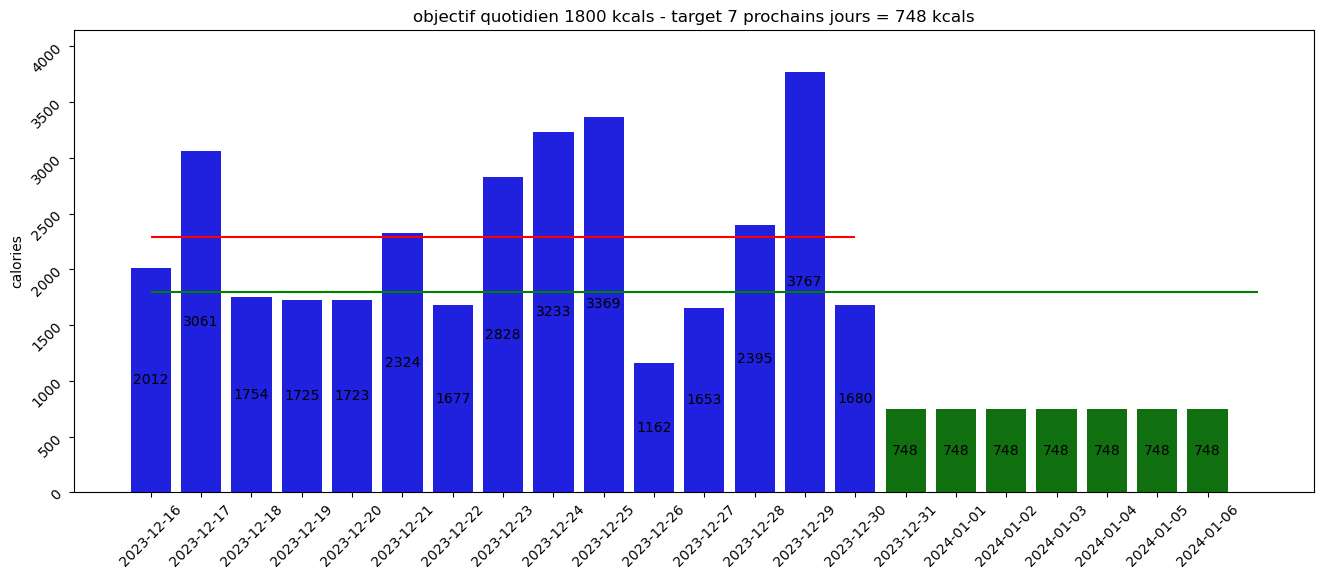

In [16]:
# plot data
fig, ax = plt.subplots(figsize=(16, 6))

tick_label = list(df_food.index[n_jours-PERIODE:]) + [ df_food.index[-1] + datetime.timedelta(days=d) for d in range(1,n_jours+1 )]
listcals = list(df_food['Calories'][n_jours-PERIODE:]) + [ target ] * n_jours

colors = [ 'blue'] * (PERIODE-n_jours) + ['green'] * n_jours
sns.barplot(x=tick_label, y=listcals, ax=ax, palette=colors)

# annotate
ax.bar_label(ax.containers[0], label_type='center', fmt="%.0f")
ax.tick_params(labelrotation=45)

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

ax.set_ylabel('calories')
ax.set_title(f'objectif quotidien {MAX_CAL:.0f} kcals - target {n_jours} prochains jours = {target:.0f} kcals')

ax.hlines(y=avg, xmin=0, xmax=PERIODE-n_jours-1, colors=['red'])
ax.hlines(y=MAX_CAL, xmin=0, xmax=PERIODE, colors=['green'])

plt.show()

In [17]:
# df_food.rolling(window=7).mean().tail(15)

In [18]:
def extract_data_training(exo_dict):
    # utility fonction pour récupérer : date, durée, type exercice et calories dépensées
    
    # récupère date
    pattern = '2(\d){3,3}-(\d){2,2}-(\d){2,2}'  # on cherche une date du type 2xxx-yy-zz
    p = re.compile(pattern)
    m = p.search(exo_dict.get('startTime'))
    if m: 
        time_format = '%Y-%m-%d'
        exo_date = datetime.datetime.strptime( exo_dict.get('startTime')[:10], time_format ).date()
    
    # récupère durée
    pattern = '(\d)+[.]?(\d)*'  # on cherche une durée du type xxxx.yyyy
    p = re.compile(pattern)
    m = p.search(exo_dict.get('duration'))
    if m:
        exo_duration = float(m.group())
    
    # récupère type activité et calories dépensées
    d = exo_dict.get('exercises')[0]   
    exo_type = d.get('sport')
    if d.get('kiloCalories'):
        exo_cals = float(d.get('kiloCalories'))
    else:
        exo_cals = 0.0
    
    return exo_date, exo_duration, exo_type, exo_cals

In [19]:
# Récupère les données EXERCICE

polar_filename = import_pathname + "polar"  # données de Polar

with ZipFile(polar_filename, 'r') as polar_zip:
    output_dir = polar_zip.namelist()
    
    target = 'training-session'
    dict_all_exos = {}
    for i, enr_name in enumerate(tqdm(output_dir)): # on parcourt la liste des archives
        if enr_name[:len(target)] == target:  # si c'est un enregistrement d'une session de training, on traite
            enr_json = polar_zip.extract(enr_name, path=import_pathname)   # extraction du json
            with open(enr_json, 'r') as f:
                exo_dict = json.load(f)
                exo_date, exo_duration, exo_type, exo_cals = extract_data_training(exo_dict)
                if dict_all_exos.get(exo_date) == None:
                    dict_all_exos[exo_date] = [ exo_duration, exo_cals]
                else:
                    dict_all_exos[exo_date] = [ dict_all_exos[exo_date][0] + exo_duration, dict_all_exos[exo_date][1] + exo_cals ]
                # print(f'exercice {i+1} : date = {exo_date}, durée = {exo_duration}, type = {exo_type}, cals = {exo_cals}')
            os.remove(enr_json)
    
    df_exos = pd.DataFrame.from_dict(dict_all_exos, orient='index', columns=['exo_duree', 'exo_cals_bruts']).sort_index()

100%|██████████| 1789/1789 [00:57<00:00, 31.07it/s]


In [20]:
df_exos.tail(15)

,exo_duree,exo_cals_bruts
2023-11-27,3780.702,360.0
2023-11-29,3540.595,336.0
2023-11-30,1861.157,274.0
2023-12-01,3120.704,263.0
2023-12-03,5892.579,528.0
2023-12-05,3540.597,271.0
2023-12-06,1940.959,286.0
2023-12-07,1980.953,308.0
2023-12-08,3120.828,274.0
2023-12-10,5700.705,538.0


In [21]:
# Ajout à la main des exos depuis le xx Janvier inclus pour palier à la fréquence de rafraîchissement de l'extraction Polar

# récupère fichier brut .csv
exos_persos_filename = "/home/benjamin/Folders_Python/Weight_imports/Exos_Persos.csv"
df_exos_persos = pd.read_csv(exos_persos_filename)

# convertit la colonne Jour en datetime objects en colonne Date
pattern_date = '[\d]{2}/[\d]{2}/[\d]{2}'
p = re.compile(pattern_date)

day_format = "%d/%m/%y"

df_exos_persos['Date'] = df_exos_persos['Jour'].apply( lambda x : datetime.datetime.strptime(p.search(x).group(0), day_format).date() )

# drope la colonne Jour, somme tous les exercices par date
df_exos_persos.drop(columns=['Jour'], inplace=True)

df_exos_persos = df_exos_persos.groupby('Date').sum()

# met au bon format la duree de l'exercice (minutes => secondes)
df_exos_persos['exo_duree'] = df_exos_persos['Duree'] * 60
df_exos_persos.drop(columns=['Duree'], inplace=True)

In [22]:
df_exos_persos

,exo_cals_bruts,exo_duree
Date,,
2023-12-17,0,0
2023-12-18,238,3120
2023-12-19,204,1560
2023-12-20,154,1920
2023-12-21,0,0
2023-12-22,341,3120
2023-12-23,0,0
2023-12-24,207,3060
2023-12-25,392,3120


In [23]:
# enfin, concatène avec le fichier issu de Polar
df_exos_total = pd.concat( [df_exos, df_exos_persos], axis=0 ).sort_index()

In [24]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
2023-12-16,4920.615,536.0
2023-12-17,0.000,0.0
2023-12-18,3120.000,238.0
2023-12-19,1560.000,204.0
2023-12-20,1920.000,154.0
2023-12-21,0.000,0.0
2023-12-22,3120.000,341.0
2023-12-23,0.000,0.0
2023-12-24,3060.000,207.0
2023-12-25,3120.000,392.0


In [25]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
2023-12-16,3405.968714,334.285714
2023-12-17,2960.136143,295.142857
2023-12-18,2591.464000,252.285714
2023-12-19,2348.863571,233.285714
2023-12-20,2383.030857,220.571429
2023-12-21,1868.745143,192.000000
2023-12-22,2091.516429,210.428571
2023-12-23,1388.571429,133.857143
2023-12-24,1825.714286,163.428571
2023-12-25,1825.714286,185.428571


In [26]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [27]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [28]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [29]:
# df_all.head(20)
# df_all.describe(include='all')
# df_all.info()

In [30]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-12-16,70.810000,11.339000,2.975000,56.479000,39.745000,0.160133,1654.573600,2012.4,32.1,341.2,97.4,4920.615,536.0,441.769448,2096.343048,-83.943048
2023-12-17,71.602000,11.254000,3.021000,57.310000,40.627000,0.157174,1673.516800,3061.0,146.8,247.9,196.9,0.000,0.0,0.000000,1673.516800,1387.483200
2023-12-18,71.108333,11.918333,2.959167,56.214167,39.367500,0.167608,1648.504000,1754.2,70.0,112.8,180.8,3120.000,238.0,178.470689,1826.974689,-72.774689
2023-12-19,70.900000,11.595000,2.966000,56.322000,39.531000,0.163540,1650.988000,1725.4,50.5,164.8,164.5,1560.000,204.0,174.190494,1825.178494,-99.778494
2023-12-20,71.554000,11.877000,2.985000,56.677000,39.836000,0.165987,1659.023200,1722.6,43.4,155.7,166.8,1920.000,154.0,117.132818,1776.156018,-53.556018
2023-12-21,71.916923,11.780000,3.006923,57.113846,40.296923,0.163800,1668.957538,2323.6,82.0,186.7,220.8,0.000,0.0,0.000000,1668.957538,654.642462
2023-12-22,71.452500,11.557500,2.997500,56.885000,40.113333,0.161751,1663.732000,1677.4,28.5,183.1,177.4,3120.000,341.0,280.920789,1944.652789,-267.252789
2023-12-23,71.721538,11.783846,2.998462,56.925385,40.103077,0.164300,1664.654154,2827.7,87.2,306.3,199.5,0.000,0.0,0.000000,1664.654154,1163.045846
2023-12-24,72.307500,11.954167,3.018333,57.321667,40.469167,0.165324,1673.632000,3232.7,130.4,415.9,93.5,3060.000,207.0,147.725533,1821.357533,1411.342467
2023-12-25,73.006000,12.387000,3.029000,57.574000,40.636000,0.169671,1679.370400,3369.1,120.8,341.6,168.8,3120.000,392.0,331.356069,2010.726469,1358.373531


In [31]:
file_save = os.getcwd() + "/data/dataset.csv"

with open(file_save, 'w') as f:
    df_all.to_csv(file_save)

In [32]:
df_all.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-12-16,71.568069,11.474078,3.007253,57.070537,40.340926,0.160308,1668.030213,1750.585714,42.242857,189.814286,154.928571,2960.136143,295.142857,238.025492,1906.055705,-155.469991
2023-12-17,71.524903,11.392983,3.009777,57.106251,40.397045,0.159275,1668.849470,1974.814286,59.000000,199.528571,163.900000,2145.749714,218.285714,176.888477,1845.737947,129.076338
2023-12-18,71.389950,11.372745,3.004087,56.996703,40.291545,0.159308,1666.371642,2003.771429,66.228571,195.428571,160.514286,2591.464000,252.285714,202.384290,1868.755931,135.015497
2023-12-19,71.242548,11.330342,2.998970,56.896729,40.198442,0.159054,1664.103642,1990.914286,67.428571,192.542857,158.085714,2348.863571,233.285714,188.105586,1852.209228,138.705058
2023-12-20,71.278476,11.382294,2.998374,56.881777,40.172513,0.159699,1663.757527,1980.600000,66.842857,184.542857,163.814286,2383.030857,220.571429,174.741965,1838.499492,142.100508
2023-12-21,71.339465,11.524762,2.992870,56.805573,40.052203,0.161552,1661.997591,2054.100000,69.928571,185.985714,177.014286,1868.745143,192.000000,156.178138,1818.175730,235.924270
2023-12-22,71.334822,11.617262,2.987227,56.714430,39.930965,0.162856,1659.899305,2039.514286,64.757143,198.885714,172.085714,2091.516429,210.428571,170.354891,1830.254197,209.260089
2023-12-23,71.465042,11.680811,2.990579,56.778200,39.982119,0.163451,1661.339385,2155.985714,72.628571,193.900000,186.671429,1388.571429,133.857143,107.244970,1768.584355,387.401360
2023-12-24,71.565828,11.780835,2.990198,56.779866,39.959571,0.164616,1661.355842,2180.514286,70.285714,217.900000,171.900000,1825.714286,163.428571,128.348618,1789.704459,390.809826
2023-12-25,71.836923,11.847788,3.000174,56.974128,40.140786,0.164910,1665.765327,2411.214286,77.542857,250.585714,170.185714,1825.714286,185.428571,150.189386,1815.954714,595.259572


# Graphes

In [33]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 'cal_deficit',

dict_hlines = {
        'Calories' : [ (1600, 'green'), (1700, 'orange'), (1800, 'red') ],
        'cal_deficit' : [ (-500, 'green'), (-200, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.14, 'green'), (.15, 'orange'), (.16,'red') ]
    }

In [34]:
def plot_general(longueur=15,
                 year=2023,
                 month=9,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

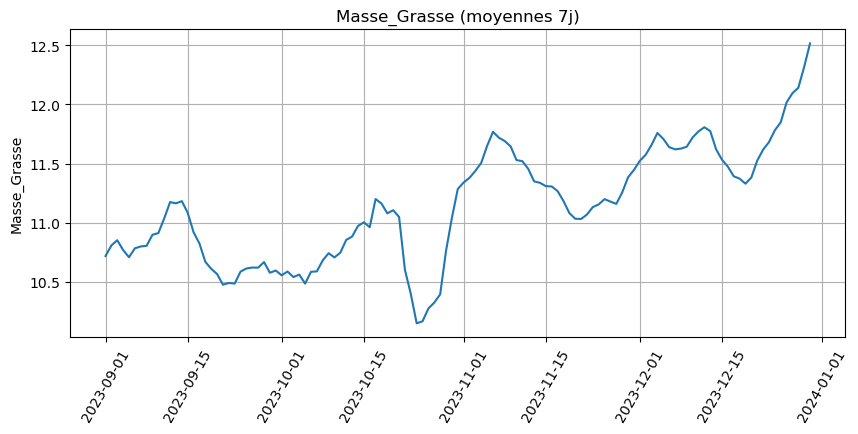

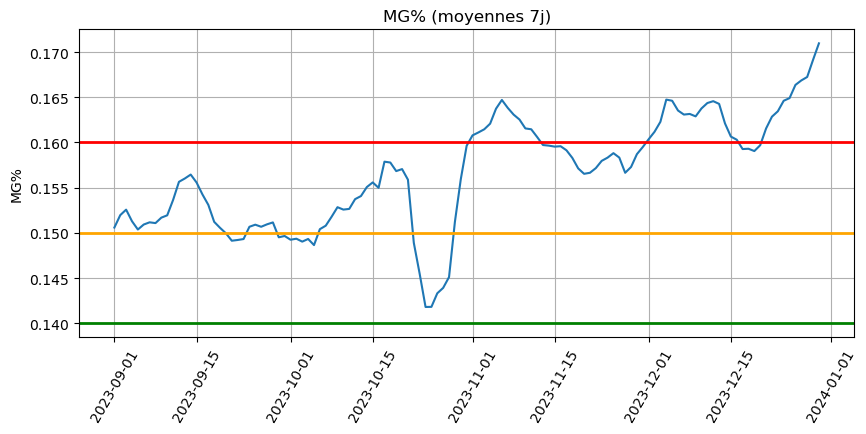

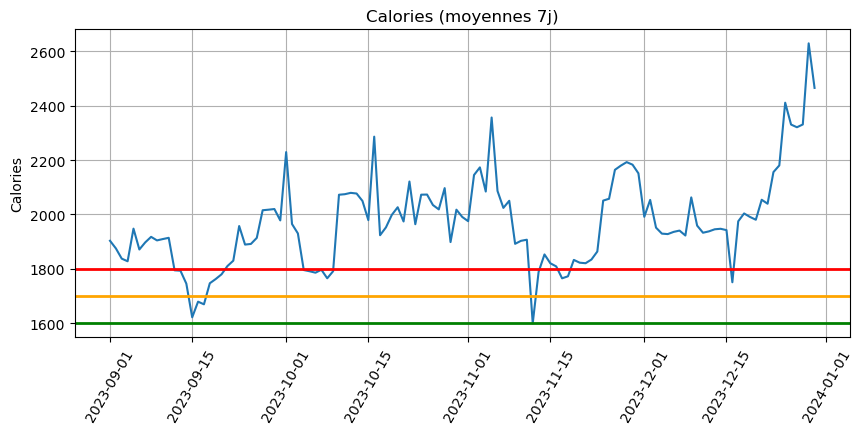

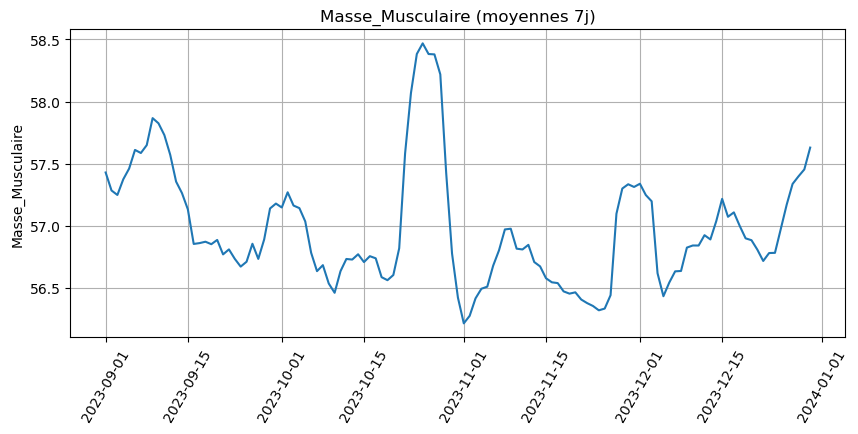

In [35]:
plot_general(longueur=7)

In [36]:
vars = ['Masse_Grasse', 'MG%', 'Calories','Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire',  'cal_deficit', 

ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general(longueur=15, year=2023, month=9, day=1)>

In [37]:
def plot_general2(longueur=15,
                 year=2023,
                 month=9,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-400.0, top=500.0)
    # ax2.legend()

In [38]:
# ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

In [39]:
def plot_general3(longueur=15,
                 year=2023,
                 month=9,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1500.0, top=2500.0)
    # ax2.legend()

In [40]:
ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general3(longueur=15, year=2023, month=9, day=1)>

In [41]:
def scatter_plot(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['cal_deficit'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    # print(delta)
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie deficit over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight change (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=-500, stop=500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')
    

In [42]:
# ipywidgets.interact(scatter_plot, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [43]:
def scatter_plot2(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight variation (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [44]:
# ipywidgets.interact(scatter_plot2, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [45]:
def scatter_plot3(mass_interval=5.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_MG'] = (df_corr['Masse_Grasse'] - df_corr['Masse_Grasse'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_MG'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly fat mass variation over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [46]:
ipywidgets.interact(scatter_plot3, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=5.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot3(mass_interval=5.0, length=15)>